# 2-8. 프로젝트: 어떤 예측 모형이 차량 수요 예측에 가장 적합할까?
**Step 1. 학습 데이터와 테스트 데이터 나누기**<br>

In [68]:
import os
import requests
from io import BytesIO
from itertools import product
from datetime import datetime

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# 분석
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import statsmodels.api as sm
import pmdarima as pm  

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller # 정상성 검정
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings( 'ignore' )

print("슝~")

슝~


In [69]:
print( f'# pandas:       {pd.__version__}' )
print( f'# numpy:        {np.__version__}' )
print( f'# matplotlib:   {mpl.__version__}' )  
print( f'# seaborn:      {sns.__version__}' )
print( f'# statsmodels:  {sm.__version__}' )
print( f'# scikit-learn: {sklearn.__version__}' )
print( f'# pmdarima:     {pm.__version__}' )

# pandas:       1.2.0
# numpy:        1.19.5
# matplotlib:   3.3.3
# seaborn:      0.11.1
# statsmodels:  0.12.1
# scikit-learn: 0.23.0
# pmdarima:     1.8.3


In [70]:
file_path_raws = os.getenv('HOME') + '/aiffel/demand_forecasting/data/raws.csv'
df_raws = pd.read_csv(file_path_raws)

df_op_ts = df_raws.set_index('target_dates').sort_index()
df_op_ts.head()

,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,op_rate_1d_major_cars,...,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week,weekday,is_weekend
target_dates,,,,,,,,,,,,,,,,,,,,,
2019-09-08,0.381038,0.134719,0.095673,0.081302,0.073248,0.067846,0.059269,0.050881,0.392379,0.130225,...,3850,1190,0,18.8,24.4,9,2019,36,6,True
2019-09-09,0.294693,0.094521,0.058669,0.049279,0.040270,0.033519,0.029069,0.024346,0.316189,0.095190,...,2392,1777,0,90.4,24.7,9,2019,37,0,False
2019-09-10,0.327382,0.115586,0.065420,0.050327,0.043757,0.035807,0.030258,0.026159,0.359647,0.119441,...,2827,2526,0,127.7,24.9,9,2019,37,1,False
2019-09-11,0.382523,0.149016,0.094511,0.073380,0.062836,0.055696,0.048563,0.043774,0.409784,0.142832,...,5867,5083,0,98.4,24.1,9,2019,37,2,False
2019-09-12,0.559916,0.266497,0.201238,0.166553,0.143653,0.130768,0.119568,0.106934,0.568754,0.241148,...,9692,9838,0,38.8,21.3,9,2019,37,3,False


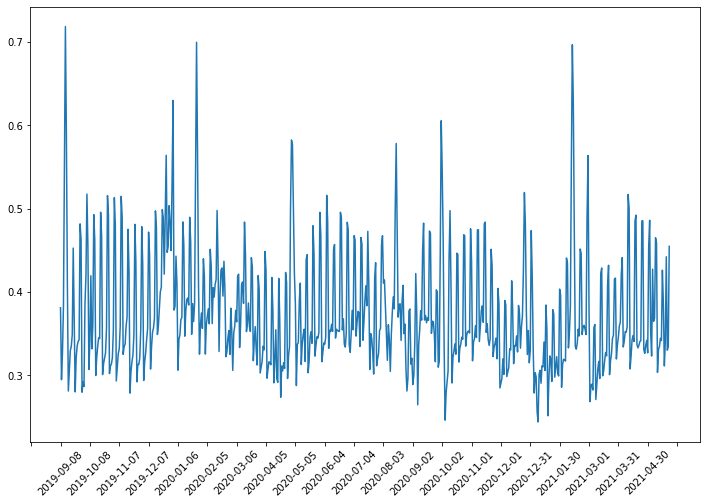

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))  
plt.plot(df_op_ts['op_rate_0d_all_cars'])
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=30.0) 
ax.xaxis.set_major_locator(loc)
plt.show()

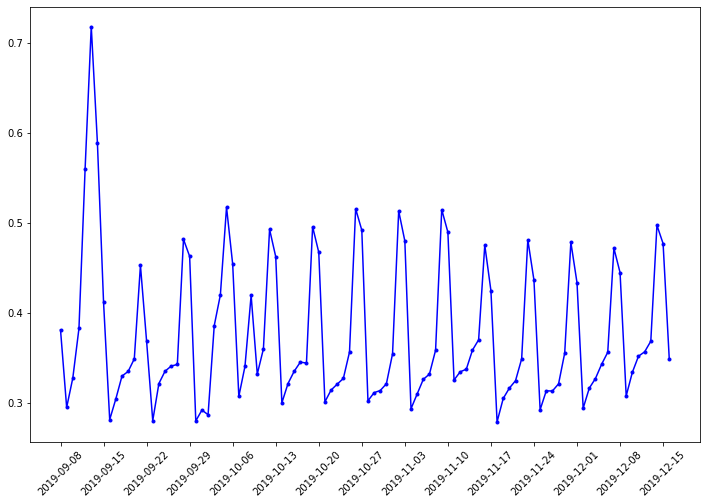

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))  
plt.plot(df_op_ts['op_rate_0d_all_cars'][0:100], "b.-")
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)
plt.show()

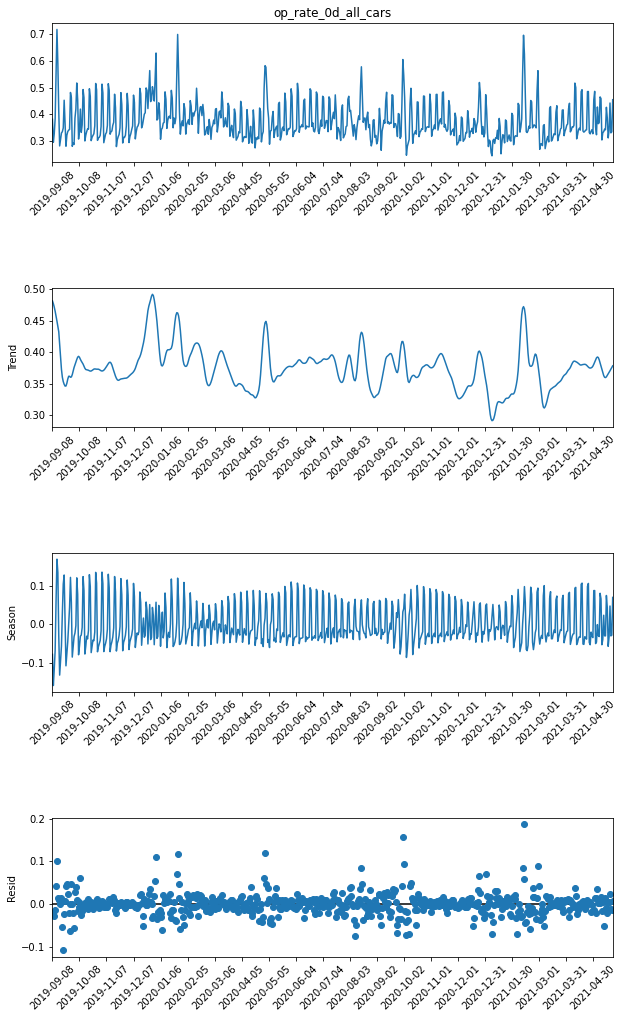

target_dates
2019-09-13    0.100568
2020-01-01    0.110451
2020-01-25    0.117945
2020-05-01    0.120080
2020-10-01    0.156595
2021-02-12    0.187517
Name: resid, dtype: float64


In [73]:
time_series_op_rate = df_op_ts['op_rate_0d_all_cars'] # Create univariate time series
STL_decomposed = STL(time_series_op_rate, seasonal=7, period=7).fit()
fig = STL_decomposed.plot()
fig.set_size_inches(10, 16)

for ax in fig.axes :
    loc = plticker.MultipleLocator(base=30.0) 
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_minor_locator(loc)
    ax.tick_params(axis='x', labelrotation=45)
    
plt.show()
print(STL_decomposed.resid[STL_decomposed.resid>0.1]) # 가설 검증

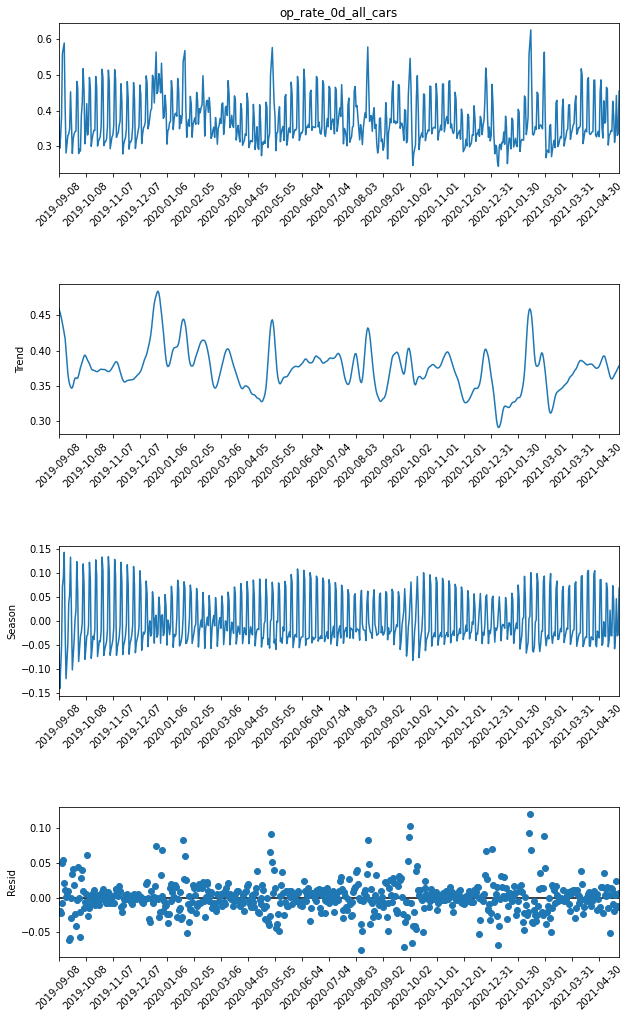

target_dates
2020-10-02    0.103744
2021-02-12    0.121464
Name: resid, dtype: float64


In [74]:
time_series_op_rate_replace = time_series_op_rate.copy()
time_series_op_rate_replace[STL_decomposed.resid>0.1] = np.NaN
time_series_op_rate_replace = time_series_op_rate_replace.interpolate(method='linear') # Linear interpolation

# Outlier를 처리한 뒤의 STL Decomposition
STL_decomposed_replace = STL(time_series_op_rate_replace, seasonal=7, period=7).fit()
fig = STL_decomposed_replace.plot()
fig.set_size_inches(10, 16)

for ax in fig.axes :
    loc = plticker.MultipleLocator(base=30.0) 
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_minor_locator(loc)
    ax.tick_params(axis='x', labelrotation=45)
    
plt.show()
print(STL_decomposed_replace.resid[STL_decomposed_replace.resid>0.1])

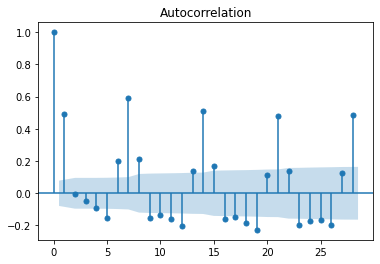

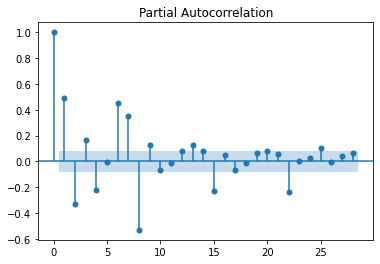

In [75]:
# ACF, PACF plot
plot_acf(time_series_op_rate_replace)
plot_pacf(time_series_op_rate_replace)
plt.show()

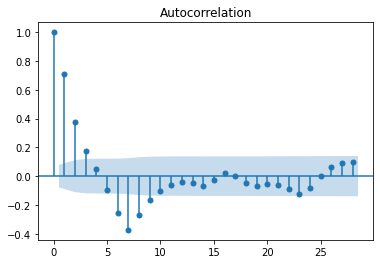

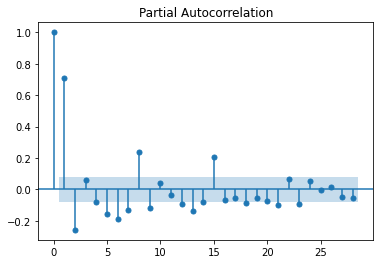

In [76]:
# 차분 
time_series_op_rate_diff = time_series_op_rate_replace.diff(7).dropna()
plot_acf(time_series_op_rate_diff)
plot_pacf(time_series_op_rate_diff)
plt.show()

p-value of ADF test (diff 7): 1.537781597872186e-12


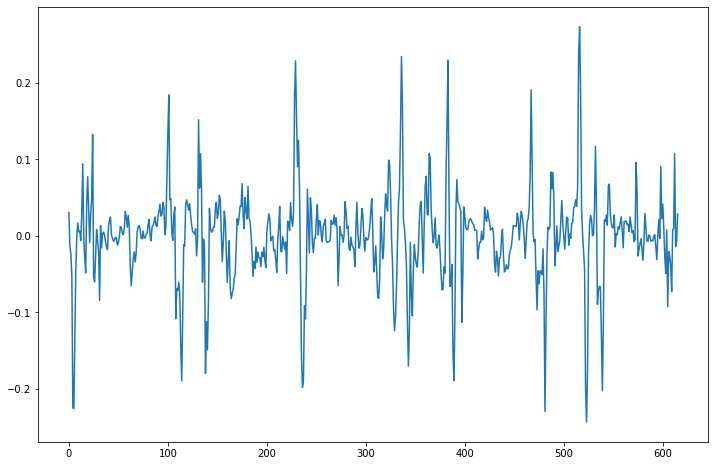

In [77]:
p_value = adfuller(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars)[1]
print(f'p-value of ADF test (diff 7): {p_value}')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

plt.plot(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars);

plt.show()

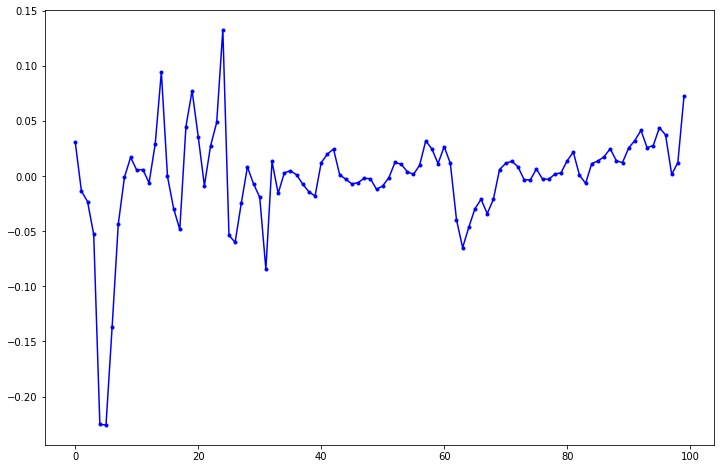

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

plt.plot(time_series_op_rate_diff.reset_index().op_rate_0d_all_cars[0:100], "b.-")

plt.show()

In [79]:
# Split Train/Test data
op_rate_train = time_series_op_rate_diff[time_series_op_rate_diff.index<'2021-04-01']
op_rate_test = time_series_op_rate_diff[time_series_op_rate_diff.index>='2021-04-01']

model = ARIMA(op_rate_train, order=(3, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                               ARIMA Model Results                               
Dep. Variable:     D.op_rate_0d_all_cars   No. Observations:                  563
Model:                    ARIMA(3, 1, 1)   Log Likelihood                1009.256
Method:                          css-mle   S.D. of innovations              0.040
Date:                   Mon, 04 Oct 2021   AIC                          -2006.513
Time:                           14:29:53   BIC                          -1980.513
Sample:                       09-16-2019   HQIC                         -1996.363
                            - 03-31-2021                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        6.587e-06   3.17e-05      0.208      0.835   -5.55e-05    6.87e-05
ar.L1.D.op_rate_0d_all_cars     0.9613      0.042     22

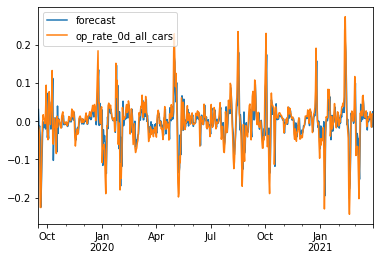

In [80]:
fitted_m.plot_predict()
plt.show()

Test RMSE: 0.03458761823929783



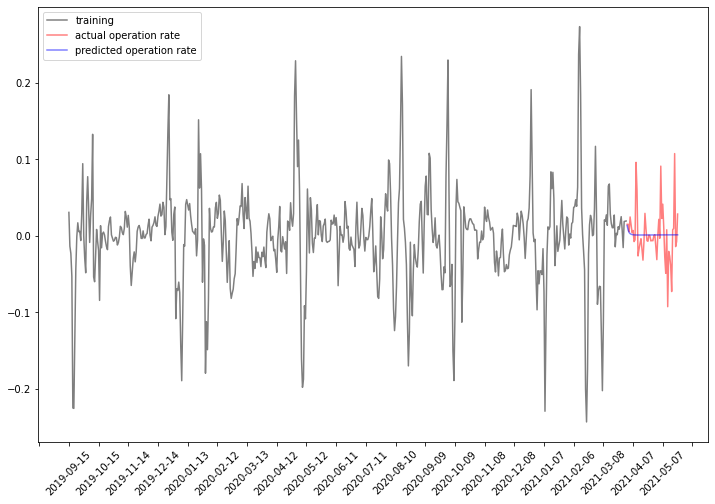

In [81]:
fc, se, conf = fitted_m.forecast(len(op_rate_test), alpha=0.05)  # 95% conf

arima_rmse = np.sqrt(sklearn.metrics.mean_squared_error(op_rate_test, fc))
print(f'Test RMSE: {arima_rmse}\n')

# Make as pandas series
fc_series = pd.Series(fc, index=op_rate_test.index)   # 예측결과


# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

plt.plot(op_rate_train, alpha=0.5, color='black', label='training')
plt.plot(op_rate_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(fc_series, alpha=0.5, color='blue', label='predicted operation rate')
plt.legend()

plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=30.0) 
ax.xaxis.set_major_locator(loc)

plt.show()

In [82]:
model_auto_arima = pm.auto_arima(op_rate_train, seasonal=True, m=7, D=1)
print('슝~')

슝~


In [83]:
print(model_auto_arima)
print(model_auto_arima.params())
print(model_auto_arima.aic())

 ARIMA(5,0,1)(2,1,0)[7]          
[ 1.37567276 -0.75161166  0.28140888 -0.06181173 -0.09067537 -0.44761935
 -0.81077637 -0.478058    0.0021468 ]
-1816.5964015531426


Test RMSE: 0.03715095735183684



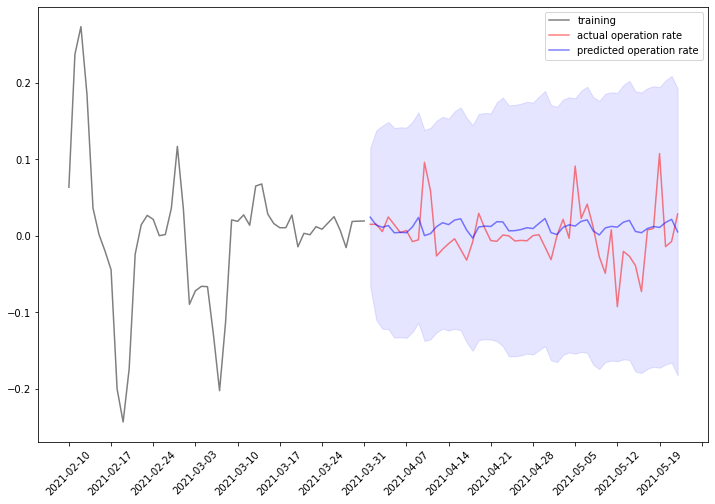

In [84]:
op_rate_pred, conf_int = model_auto_arima.predict(n_periods=op_rate_test.shape[0], return_conf_int=True)
sarima_rmse = np.sqrt(sklearn.metrics.mean_squared_error(op_rate_test, op_rate_pred))
print(f'Test RMSE: {sarima_rmse}\n')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(op_rate_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(op_rate_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(op_rate_test.index.values, op_rate_pred, alpha=0.5, color='blue', label='predicted operation rate')
plt.fill_between(op_rate_test.index.values, conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b') # Confidence Interval
plt.legend()
plt.show()

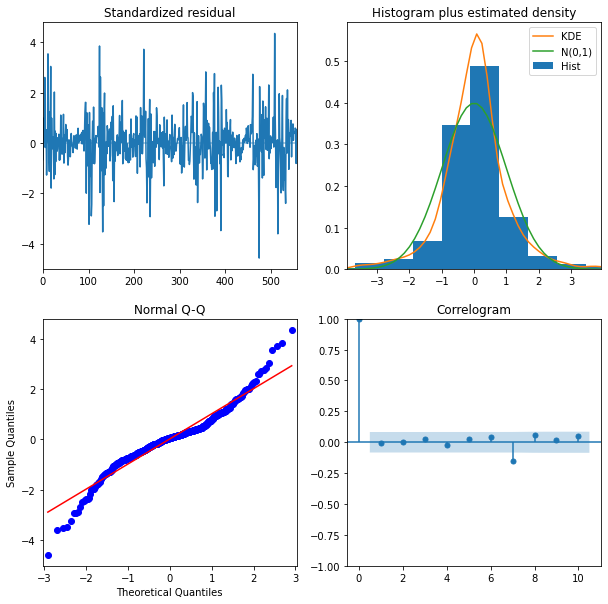

In [85]:
model_auto_arima.plot_diagnostics(figsize=(10, 10))
plt.show()

**프로젝트 Step.1**

In [86]:
# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday = pd.get_dummies(df_raws['weekday'], prefix='weekday', drop_first=False)

_x_data = pd.concat([_x_data, _x_weekday], axis=1)

_x_data.set_index("target_dates", drop=True, inplace=True)

# 예측 대상 데이터 설정
target = df_raws[['op_rate_0d_all_cars', 'target_dates' ]]

target.set_index("target_dates", drop=True, inplace=True)

# Train/Test 데이터셋 나누기
_x_data_train = _x_data[_x_data.index<'2021-04-01']
_x_data_test = _x_data[_x_data.index>='2021-04-01']
target_train = target[target.index<'2021-04-01']
target_test = target[target.index>='2021-04-01']

In [87]:
x_train = _x_data_train
x_test = _x_data_test
y_train = target_train
y_test = target_test

In [88]:
# Dataset
friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content
data = pd.read_stata(BytesIO(friedman2))
data.index = data.time
data.index.freq = "QS-OCT"

data.head()

,m2,time,m1,consump,pc92
time,,,,,
1946-01-01,NaN,1946-01-01,NaN,134.899994,NaN
1946-04-01,NaN,1946-04-01,NaN,140.100006,NaN
1946-07-01,NaN,1946-07-01,NaN,148.899994,NaN
1946-10-01,NaN,1946-10-01,NaN,153.199997,NaN
1947-01-01,NaN,1947-01-01,NaN,156.600006,912.099976


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 211 entries, 1946-01-01 to 1998-07-01
Freq: QS-OCT
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   m2       159 non-null    float32       
 1   time     211 non-null    datetime64[ns]
 2   m1       159 non-null    float32       
 3   consump  211 non-null    float32       
 4   pc92     207 non-null    float32       
dtypes: datetime64[ns](1), float32(4)
memory usage: 6.6 KB


In [90]:
# 결측치 확인
data.isnull().sum()

m2         52
time        0
m1         52
consump     0
pc92        4
dtype: int64

In [91]:
data[data['m1'].isnull()]

,m2,time,m1,consump,pc92
time,,,,,
1946-01-01,NaN,1946-01-01,NaN,134.899994,NaN
1946-04-01,NaN,1946-04-01,NaN,140.100006,NaN
1946-07-01,NaN,1946-07-01,NaN,148.899994,NaN
1946-10-01,NaN,1946-10-01,NaN,153.199997,NaN
1947-01-01,NaN,1947-01-01,NaN,156.600006,912.099976
1947-04-01,NaN,1947-04-01,NaN,160.500000,928.500000
1947-07-01,NaN,1947-07-01,NaN,164.100006,931.900024
1947-10-01,NaN,1947-10-01,NaN,168.199997,932.099976
1948-01-01,NaN,1948-01-01,NaN,170.899994,936.200012


In [92]:
# Variables
endog = data.loc['1959':, 'consump']
exog = sm.add_constant(data.loc['1959':, 'm2'])
nobs = endog.shape[0]

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,0,1))
fit_res = mod.fit(disp=False, maxiter=250)
print(fit_res.summary())

                               SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                  159
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -718.508
Date:                Mon, 04 Oct 2021   AIC                           1447.015
Time:                        14:32:15   BIC                           1462.360
Sample:                    01-01-1959   HQIC                          1453.247
                         - 07-01-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -235.0780   1.28e+04     -0.018      0.985   -2.54e+04    2.49e+04
m2             1.0000      0.091     11.022      0.000       0.822       1.178
ar.L1          0.9997      0.001    674.848      0.0

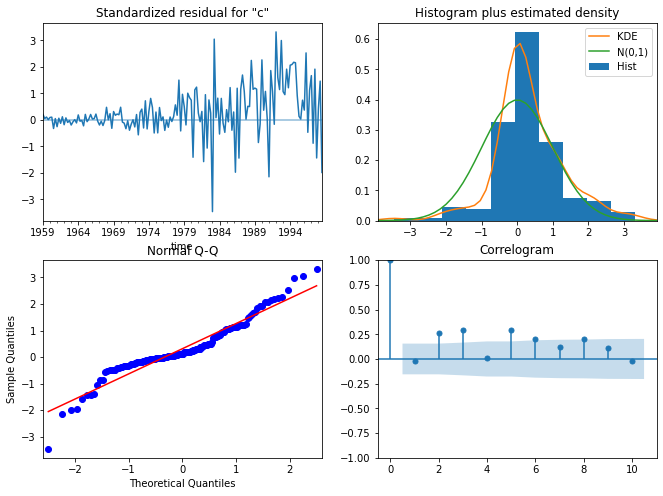

In [93]:
fit_res.plot_diagnostics(figsize=(11, 8))
plt.show()

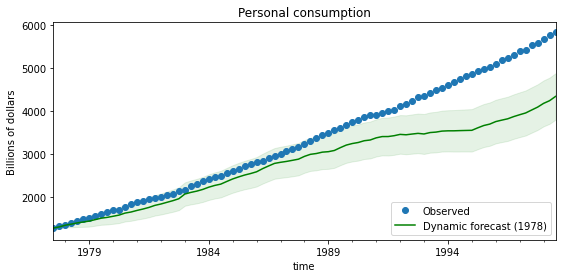

In [94]:
pred = fit_res.get_prediction(dynamic='1978-01-01')
pred_ci = pred.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
data.loc['1977-07-01':, 'consump'].plot(ax=ax, style='o', label='Observed')

# Plot predictions

pred.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
ci = pred_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

**Step 2. Grid search를 이용하여 최상의 파라미터 조합 찾기**<br>

In [95]:
# 모수
p = range(0, 2)
q = range(0, 2)
d = range(0, 2)
P = range(0, 2)
Q = range(0, 2)
D = range(0, 2)

# 초기화
best_AIC = float("inf")
best_model = sm.tsa.SARIMAX(endog=y_train, exog=x_train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 7))
iter_cnt = 0

# for 문으로 최소 AIC 찾기 (Grid Search)

### YOUR CODE ###

In [96]:
import itertools
import warnings
warnings.filterwarnings("ignore")

def sarima_grid_search(y,seasonal_period):
    p = d = q = P = Q = D = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

**Step 4. 차량 수요 예측**<br>
예측값과 예측값의 신뢰구간을 얻을 수 있는 get_forecast(steps=n)을 사용해 보세요. 학습 데이터 다음부터 지정한 steps만큼 예측할 수 있어요. RMSE와 시각화를 통해 모형의 예측 정확도를 확인해 보세요. RMSE을 구할 때는 predicted mean을 사용하고, 시각화할 때는 이전 스텝에서와 같이 마지막 50개의 데이터만 사용하세요.

In [97]:
# RMSE

### YOUR CODE ###

In [98]:
# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday = pd.get_dummies(df_raws['weekday'], prefix='weekday', drop_first=False)

_x_data = pd.concat([_x_data, _x_weekday], axis=1)

_x_data.set_index("target_dates", drop=True, inplace=True)

# 예측 대상 데이터 설정
target = df_raws[['op_rate_0d_all_cars', 'target_dates' ]]

target.set_index("target_dates", drop=True, inplace=True)

# Train/Test 데이터셋 나누기
_x_data_train = _x_data[_x_data.index<'2021-04-01']
_x_data_test = _x_data[_x_data.index>='2021-04-01']
target_train = target[target.index<'2021-04-01']
target_test = target[target.index>='2021-04-01']

# 상수항 추가
x_data_train = sm.add_constant(_x_data_train, has_constant='add')
x_data_test = sm.add_constant(_x_data_test, has_constant='add')

# OLS 선형회귀 검정
model = sm.OLS(target_train, x_data_train)
model_fit = model.fit()

# 결과물 출력
print(model_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     op_rate_0d_all_cars   R-squared:                       0.769
Model:                             OLS   Adj. R-squared:                  0.762
Method:                  Least Squares   F-statistic:                     115.0
Date:                 Mon, 04 Oct 2021   Prob (F-statistic):          3.58e-164
Time:                         14:32:16   Log-Likelihood:                 1111.5
No. Observations:                  571   AIC:                            -2189.
Df Residuals:                      554   BIC:                            -2115.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2046

In [99]:
ols_pred_test = model_fit.predict(x_data_test)
linreg_rmse = np.sqrt(sklearn.metrics.mean_squared_error(target_test, ols_pred_test))
print(f'Test RMSE: {linreg_rmse}')

Test RMSE: 0.02341016004478104


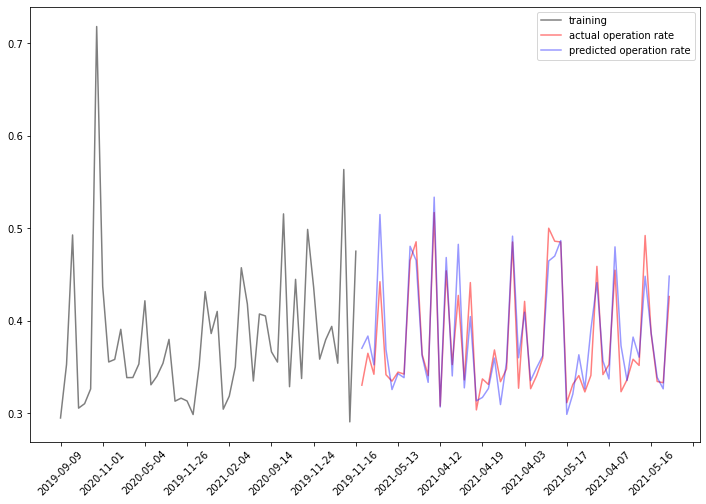

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, ols_pred_test, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

In [101]:
x_train = _x_data_train
x_test = _x_data_test
y_train = target_train
y_test = target_test

print("슝~")

슝~


In [102]:
alpha_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ridge_op_rate_cv = RidgeCV(alphas=alpha_values, cv=5).fit(x_train, y_train.values.ravel())

print(ridge_op_rate_cv.alpha_)

1.0


In [103]:
ridge_op_rate = Ridge(alpha=1).fit(x_train, y_train)
y_pred_ridge = ridge_op_rate.predict(x_test)
ridge_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_ridge))
print(f'Test RMSE: {ridge_rmse: .5f}')

Test RMSE:  0.02350


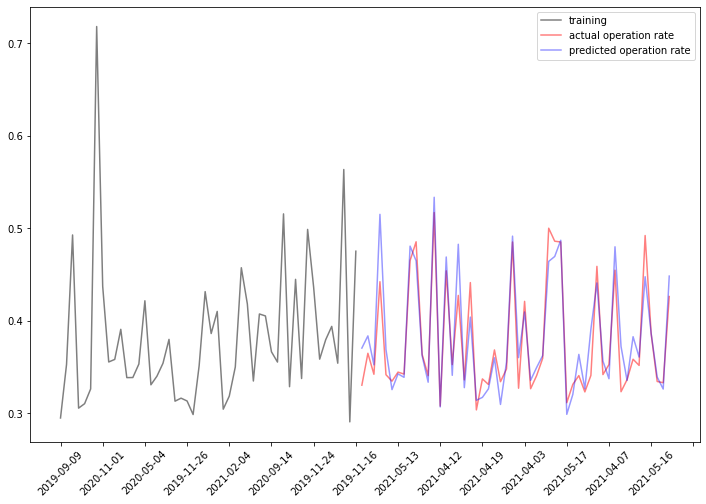

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, y_pred_ridge, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

In [105]:
alpha_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lasso_op_rate_cv = LassoCV(alphas=alpha_values, cv=5).fit(x_train, y_train)
print(lasso_op_rate_cv.alpha_)

0.0001


In [106]:
lasso_op_rate = Lasso(alpha=0.0005).fit(x_train, y_train)
y_pred_lasso = lasso_op_rate.predict(x_test)
lasso_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_lasso))
print(f'Test RMSE: {lasso_rmse}')

Test RMSE: 0.02427736127124998


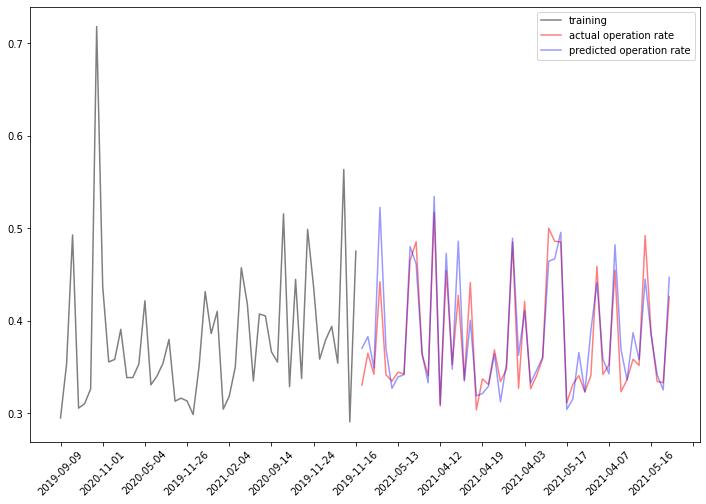

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)


plt.plot(target_train[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test.index.values, y_pred_lasso, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

In [108]:
# 시각화

### YOUR CODE ###

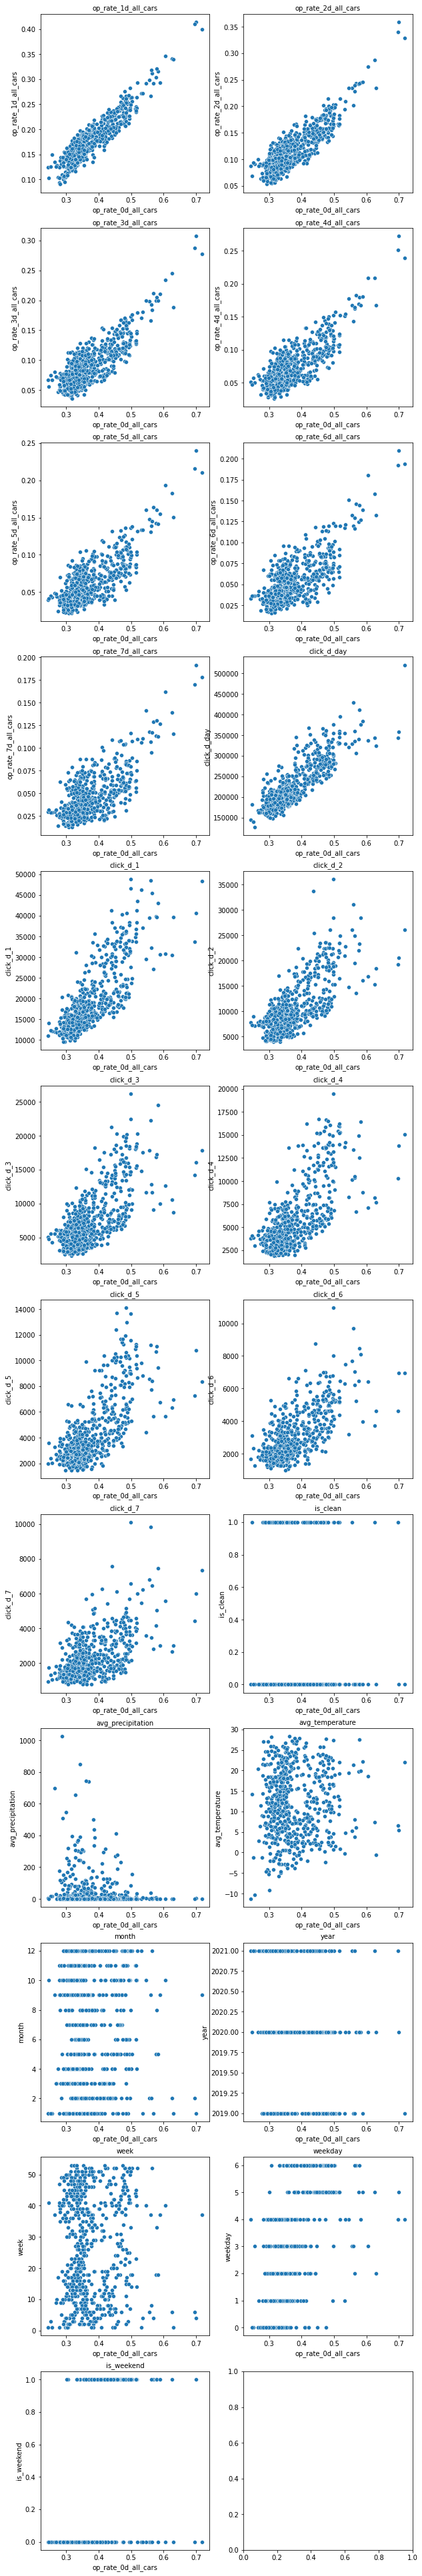

In [109]:
columns = df_raws.columns.tolist()
columns.remove('target_dates')
columns.remove('op_rate_0d_all_cars')
columns.remove('op_rate_0d_major_cars')
columns.remove('op_rate_1d_major_cars')
columns.remove('op_rate_2d_major_cars')
columns.remove('op_rate_3d_major_cars')
columns.remove('op_rate_4d_major_cars')
columns.remove('op_rate_5d_major_cars')
columns.remove('op_rate_6d_major_cars')
columns.remove('op_rate_7d_major_cars')

fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(10, 70))

for i, temp_column in enumerate(columns):
    row = i // 2
    col = i % 2
    sns.scatterplot(
        ax=axs[row, col],
        data=df_raws,
        x='op_rate_0d_all_cars',
        y=f'{temp_column}',	
    ).set_title(f'{temp_column}', fontsize=10)

plt.show()

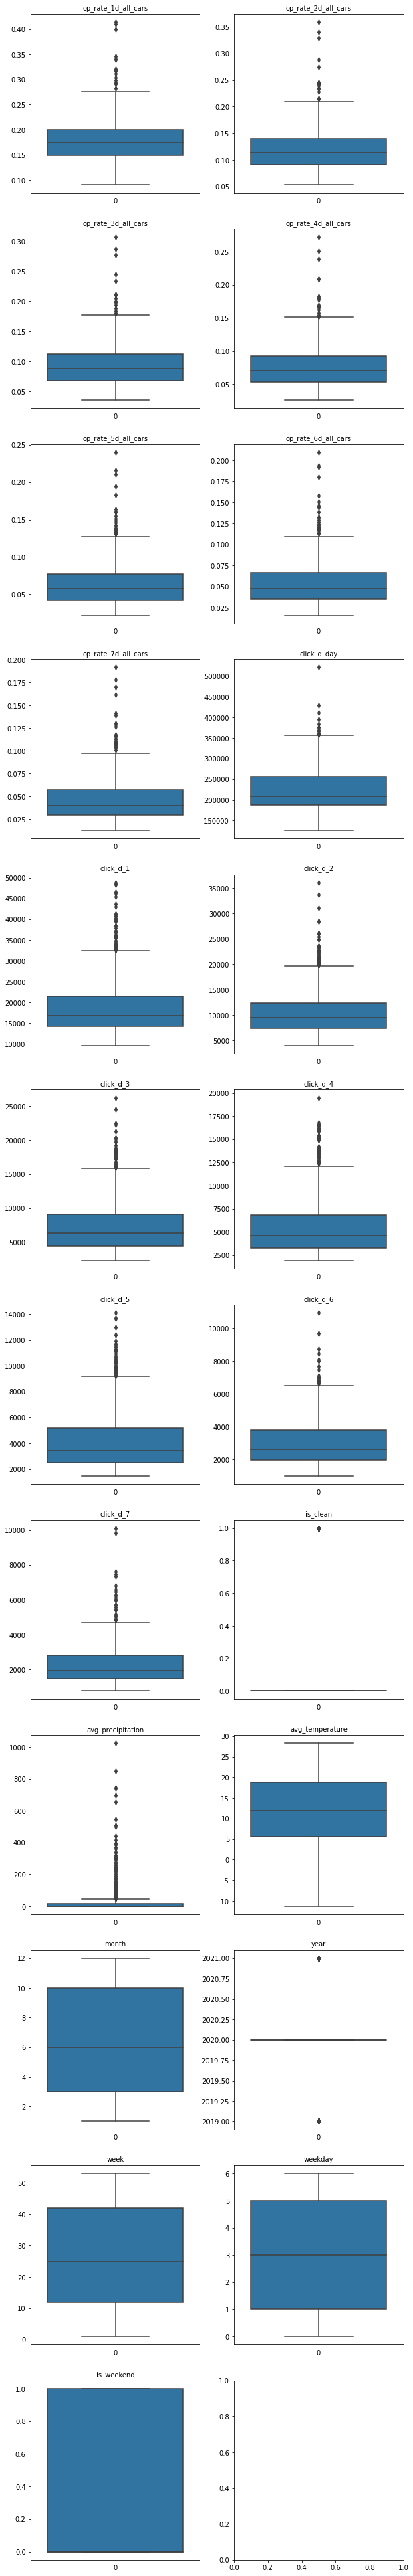

In [110]:
fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(10, 70))

for i, temp_column in enumerate(columns):
    row = i // 2
    col = i % 2
    sns.boxplot(
        ax=axs[row, col],
        data=df_raws[f'{temp_column}']	
    ).set_title(f'{temp_column}', fontsize=10)

plt.show()

In [111]:
df_clean = df_raws.copy()

# 이상치 제거 함수
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR * weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][(df[column]<lowest) | (df[column]>highest)].index
  return outlier_idx

print("쓩~")

쓩~


In [112]:
outlier_idx_click_d_1 = get_outlier(df=df_clean, column='click_d_1', weight=1.5).tolist()
outlier_idx_click_d_2 = get_outlier(df=df_clean, column='click_d_2', weight=1.5).tolist()
outlier_idx_click_d_3 = get_outlier(df=df_clean, column='click_d_3', weight=1.5).tolist()
outlier_idx_click_d_4 = get_outlier(df=df_clean, column='click_d_4', weight=1.5).tolist()
outlier_idx_click_d_5 = get_outlier(df=df_clean, column='click_d_5', weight=1.5).tolist()
outlier_idx_click_d_6 = get_outlier(df=df_clean, column='click_d_6', weight=1.5).tolist()
outlier_idx_click_d_7 = get_outlier(df=df_clean, column='click_d_7', weight=1.5).tolist()
outlier_idx_avg_precipitation = get_outlier(df=df_clean, column='avg_precipitation', weight=1.5).tolist()

print("쓩~")

쓩~


In [113]:
# 각 컬럼 outlier index 합치기
outlier_idx = outlier_idx_click_d_1 + outlier_idx_click_d_2 + outlier_idx_click_d_3 + outlier_idx_click_d_4 + outlier_idx_click_d_5 + outlier_idx_click_d_6 + outlier_idx_click_d_7 + outlier_idx_avg_precipitation 


# outlier index 중복 제거
outlier_idx_set = set(outlier_idx)
outlier_idx = list(outlier_idx_set)

len(outlier_idx)

164

In [114]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target_dates           623 non-null    object 
 1   op_rate_0d_all_cars    623 non-null    float64
 2   op_rate_1d_all_cars    623 non-null    float64
 3   op_rate_2d_all_cars    623 non-null    float64
 4   op_rate_3d_all_cars    623 non-null    float64
 5   op_rate_4d_all_cars    623 non-null    float64
 6   op_rate_5d_all_cars    623 non-null    float64
 7   op_rate_6d_all_cars    623 non-null    float64
 8   op_rate_7d_all_cars    623 non-null    float64
 9   op_rate_0d_major_cars  623 non-null    float64
 10  op_rate_1d_major_cars  623 non-null    float64
 11  op_rate_2d_major_cars  623 non-null    float64
 12  op_rate_3d_major_cars  623 non-null    float64
 13  op_rate_4d_major_cars  623 non-null    float64
 14  op_rate_5d_major_cars  623 non-null    float64
 15  op_rat

In [115]:
df_clean.head(10)

,target_dates,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,...,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week,weekday,is_weekend
0,2019-11-20,0.316167,0.128829,0.073450,0.047983,0.041501,0.035837,0.028633,0.023602,0.354157,...,1650,1318,0,0.0,3.0,11,2019,47,2,False
1,2020-09-20,0.470135,0.252650,0.181241,0.142521,0.117679,0.095518,0.076442,0.059885,0.469391,...,3808,1956,1,0.0,18.9,9,2020,38,6,True
2,2019-11-28,0.320862,0.132336,0.075752,0.052990,0.038522,0.033602,0.029606,0.025020,0.358306,...,1693,1326,0,32.1,5.1,11,2019,48,3,False
3,2020-08-31,0.313388,0.142075,0.100732,0.081107,0.063172,0.051917,0.040514,0.038404,0.319582,...,1909,1355,0,22.2,26.0,8,2020,36,0,False
4,2019-10-16,0.334846,0.128528,0.074587,0.050741,0.042454,0.035131,0.026711,0.021401,0.356267,...,1701,1025,1,0.0,13.8,10,2019,42,2,False
5,2020-08-15,0.498408,0.262441,0.202554,0.173028,0.152706,0.136340,0.123184,0.116191,0.492207,...,8021,6579,0,83.7,27.4,8,2020,33,5,True
6,2021-05-20,0.330187,0.178194,0.140476,0.112571,0.093901,0.085936,0.078562,0.070163,0.317130,...,3420,2677,1,0.0,17.7,5,2021,20,3,False
7,2020-09-28,0.309734,0.145407,0.103561,0.081475,0.064365,0.055414,0.046856,0.039182,0.315198,...,3972,2381,1,0.0,18.4,9,2020,40,0,False
8,2020-08-25,0.361382,0.178528,0.112143,0.095936,0.087493,0.079418,0.072070,0.068698,0.368897,...,3781,3302,0,10.3,28.3,8,2020,35,1,False
9,2020-06-20,0.495519,0.238302,0.166035,0.129608,0.102008,0.082998,0.065242,0.056656,0.497479,...,5398,3808,0,1.1,22.5,6,2020,25,5,True


In [116]:
df_clean.drop(outlier_idx, axis=0, inplace=True)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459 entries, 0 to 621
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target_dates           459 non-null    object 
 1   op_rate_0d_all_cars    459 non-null    float64
 2   op_rate_1d_all_cars    459 non-null    float64
 3   op_rate_2d_all_cars    459 non-null    float64
 4   op_rate_3d_all_cars    459 non-null    float64
 5   op_rate_4d_all_cars    459 non-null    float64
 6   op_rate_5d_all_cars    459 non-null    float64
 7   op_rate_6d_all_cars    459 non-null    float64
 8   op_rate_7d_all_cars    459 non-null    float64
 9   op_rate_0d_major_cars  459 non-null    float64
 10  op_rate_1d_major_cars  459 non-null    float64
 11  op_rate_2d_major_cars  459 non-null    float64
 12  op_rate_3d_major_cars  459 non-null    float64
 13  op_rate_4d_major_cars  459 non-null    float64
 14  op_rate_5d_major_cars  459 non-null    float64
 15  op_rat

In [117]:
df_clean.head(10)

,target_dates,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,...,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week,weekday,is_weekend
0,2019-11-20,0.316167,0.128829,0.073450,0.047983,0.041501,0.035837,0.028633,0.023602,0.354157,...,1650,1318,0,0.0,3.0,11,2019,47,2,False
1,2020-09-20,0.470135,0.252650,0.181241,0.142521,0.117679,0.095518,0.076442,0.059885,0.469391,...,3808,1956,1,0.0,18.9,9,2020,38,6,True
2,2019-11-28,0.320862,0.132336,0.075752,0.052990,0.038522,0.033602,0.029606,0.025020,0.358306,...,1693,1326,0,32.1,5.1,11,2019,48,3,False
3,2020-08-31,0.313388,0.142075,0.100732,0.081107,0.063172,0.051917,0.040514,0.038404,0.319582,...,1909,1355,0,22.2,26.0,8,2020,36,0,False
4,2019-10-16,0.334846,0.128528,0.074587,0.050741,0.042454,0.035131,0.026711,0.021401,0.356267,...,1701,1025,1,0.0,13.8,10,2019,42,2,False
6,2021-05-20,0.330187,0.178194,0.140476,0.112571,0.093901,0.085936,0.078562,0.070163,0.317130,...,3420,2677,1,0.0,17.7,5,2021,20,3,False
7,2020-09-28,0.309734,0.145407,0.103561,0.081475,0.064365,0.055414,0.046856,0.039182,0.315198,...,3972,2381,1,0.0,18.4,9,2020,40,0,False
8,2020-08-25,0.361382,0.178528,0.112143,0.095936,0.087493,0.079418,0.072070,0.068698,0.368897,...,3781,3302,0,10.3,28.3,8,2020,35,1,False
10,2021-02-24,0.359877,0.190760,0.123146,0.086862,0.072558,0.061313,0.049403,0.042295,0.351678,...,2518,2145,1,0.0,3.7,2,2021,8,2,False
11,2019-12-02,0.293801,0.103646,0.065057,0.051268,0.039972,0.033637,0.027370,0.023011,0.301985,...,1603,927,0,18.3,3.9,12,2019,49,0,False


In [118]:
# 설명 변수 테이블 설정
_x_data_clean = df_clean[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday_clean = pd.get_dummies(df_clean['weekday'], prefix='weekday', drop_first=False)

_x_data_clean = pd.concat([_x_data_clean, _x_weekday_clean], axis=1)

_x_data_clean.set_index("target_dates", drop=True, inplace=True)

# 예측 대상 데이터 설정
target_clean = df_clean[['op_rate_0d_all_cars', 'target_dates']]

target_clean.set_index("target_dates", drop=True, inplace=True)

# Train/Test 데이터셋 나누기
_x_data_train_clean = _x_data_clean[_x_data_clean.index<'2021-04-01']
_x_data_test_clean = _x_data_clean[_x_data_clean.index>='2021-04-01']
target_train_clean = target_clean[target_clean.index<'2021-04-01']
target_test_clean = target_clean[target_clean.index>='2021-04-01']

# 상수항 추가
x_data_train_clean = sm.add_constant(_x_data_train_clean, has_constant='add')
x_data_test_clean = sm.add_constant(_x_data_test_clean, has_constant='add')

# OLS 선형회귀 검정
model_clean = sm.OLS(target_train_clean, x_data_train_clean)
model_clean_fit = model_clean.fit()

# 결과물 출력
print(model_clean_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     op_rate_0d_all_cars   R-squared:                       0.732
Model:                             OLS   Adj. R-squared:                  0.722
Method:                  Least Squares   F-statistic:                     69.24
Date:                 Mon, 04 Oct 2021   Prob (F-statistic):          4.56e-105
Time:                         14:32:27   Log-Likelihood:                 880.09
No. Observations:                  422   AIC:                            -1726.
Df Residuals:                      405   BIC:                            -1657.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1946

In [119]:
ols_pred_test_clean = model_clean_fit.predict(x_data_test_clean)
linreg_rmse_cleaned = np.sqrt(sklearn.metrics.mean_squared_error(target_test_clean, ols_pred_test_clean))
  
print(f'.    Test RMSE: {linreg_rmse_cleaned: .5f}')
print(f'cf ) Test RMSE( non_clean ): {linreg_rmse: .5f}')

.    Test RMSE:  0.02036
cf ) Test RMSE( non_clean ):  0.02341


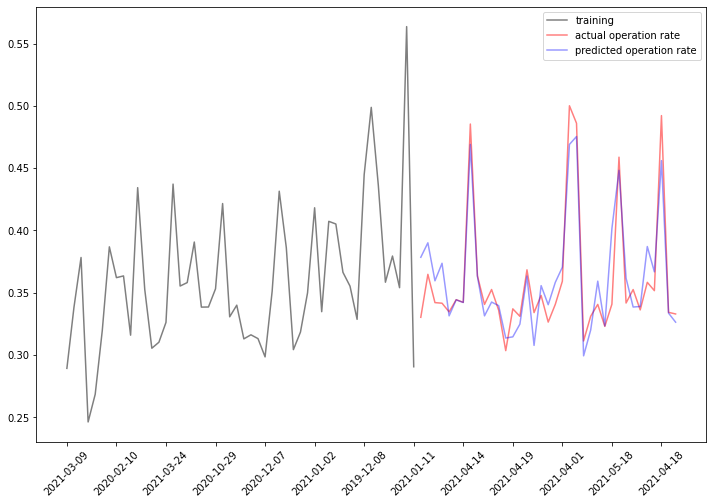

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train_clean[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test_clean, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test_clean.index.values, ols_pred_test_clean, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

In [121]:
x_train = _x_data_train_clean
x_test = _x_data_test_clean
y_train = target_train_clean
y_test = target_test_clean

alpha_values_clean = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ridge_op_rate_cv_clean = RidgeCV(alphas=alpha_values_clean, cv=5).fit(x_train, y_train.values.ravel())

print(ridge_op_rate_cv_clean.alpha_)

1.0


.    Test RMSE_cleaned:       0.02049
cf ) Test RMSE( non_clean ):  0.02350




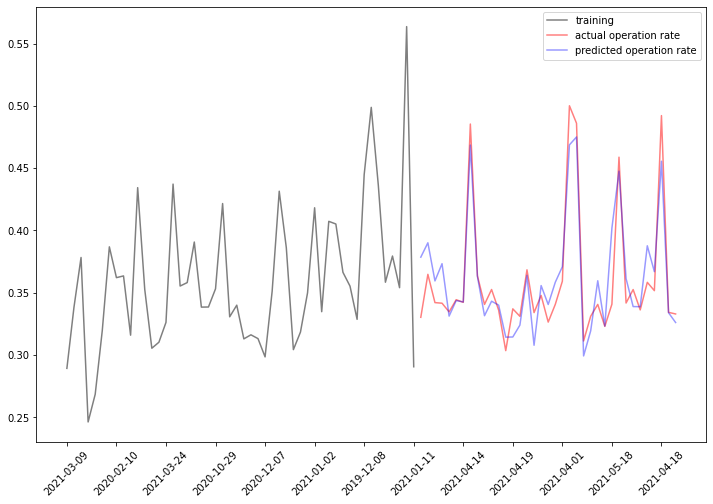

In [122]:
ridge_op_rate = Ridge(alpha=1).fit(x_train, y_train)
y_pred_ridge = ridge_op_rate.predict(x_test)
ridge_rmse_cleaned = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_ridge))
print(f'.    Test RMSE_cleaned:      {ridge_rmse_cleaned: .5f}')
print(f'cf ) Test RMSE( non_clean ): {ridge_rmse: .5f}\n\n')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)


plt.plot(target_train_clean[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test_clean, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test_clean.index.values, y_pred_ridge, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

In [123]:
alpha_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lasso_op_rate_cv = LassoCV(alphas=alpha_values, cv=5).fit(x_train, y_train.values.ravel())

print(lasso_op_rate_cv.alpha_)

0.0005


     Test RMSE:               0.02047
cf ) Test RMSE( non_clean ):  0.02428




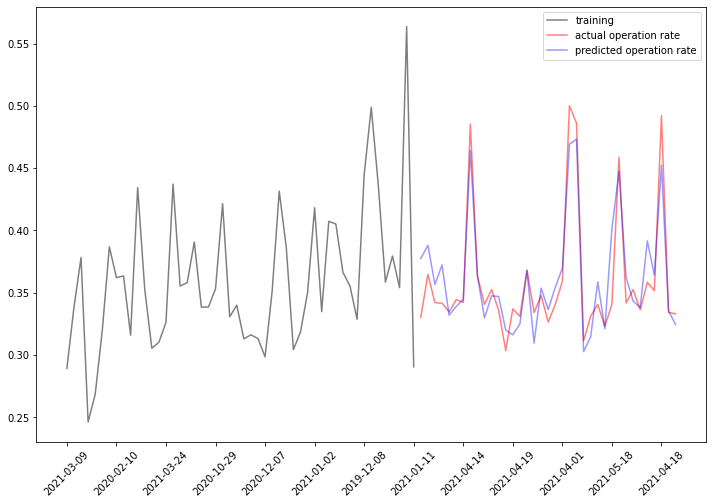

In [124]:
lasso_op_rate = Lasso(alpha=0.0005).fit(x_train, y_train)
y_pred_lasso = lasso_op_rate.predict(x_test)
lasso_rmse_cleaned = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_lasso))
print(f'     Test RMSE:              {lasso_rmse_cleaned: .5f}')
print(f'cf ) Test RMSE( non_clean ): {lasso_rmse: .5f}\n\n')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0) 
ax.xaxis.set_major_locator(loc)

plt.plot(target_train_clean[-50:], alpha=0.5, color='black', label='training')
plt.plot(target_test_clean, alpha=0.5, color='red', label='actual operation rate')
plt.plot(target_test_clean.index.values, y_pred_lasso, alpha=0.4, color='blue', label='predicted operation rate')
plt.legend()

plt.show()

**Step 5. 다른 모형 사용하기**<br>
지금까지 배운 모형이 아닌 다른 모형을 사용해 차량 수요 예측을 해보세요. 트리 기반 머신러닝 모형(LGBM, Gradient Boosting, XBG, Random Forest 등)을 사용해 보세요. 3개 이상의 모형을 사용해 차량의 수요를 예측해 보세요.

In [125]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=32)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)

print(classification_report(y_test, y_pred))

ValueError: Unknown label type: 'continuous'

In [ ]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(random_state=32)
xgboost.fit(x_train, y_train)
y_pred = xgboost.predict(x_test)

print(classification_report(y_test, y_pred))

In [ ]:
from lightgbm import lgb

lgbm = lgb.LGBMRegressor(random_state=32)
lgbm.fit(x_train, y_train)
y_pred = lgbm.predict(x_test)

print(classification_report(y_test, y_pred))

**회고**<br>
**학습했던 노드를 통 틀어서 가장 오랜 시간이 걸렸음에도 불구하고 만족하지 못한 결과물이 나온 노드였던 것 같습니다.<br>
100% 완벽히 이해하지 못했던 노드는 종종 있었지만, '동적 회귀 모형' 같은 생소한 개념은 참고자료 읽는 것만 해도 시간이 많이<br>
소요된 것 같습니다. 밀리기 전에 다시 한번 정독해서 복습하려고 합니다.**